# COMETS: From dFBA to Complex Ecosystems

This notebook is dedicated to developing a COMETS (Computation Of Microbial Ecosystems in Time and Space) simulation step by step.  Each section of this notebook incrementally adds layers to our model, illustrating the different computational methods and how they integrate.

## Overview of Steps

1. **Dynamic FBA (dFBA):** We begin with the basics of dynamic Flux Balance Analysis. dFBA allows us to model the metabolic behavior of microorganisms over time, providing insights into how they grow and consume substrates within a defined environment.

2. **Multiple Species dFBA:** Building on dFBA, we extend our model to include interactions between multiple species. This step explores how different microbial species compete for resources or benefit from the byproducts of others, highlighting the complexity of microbial communities.

3. **2D PDEs for Physical Processes:** To add spatial resolution to our simulations, we introduce two-dimensional partial differential equations (PDEs). These equations model the diffusion and advection of substances across the environment, adding a layer of physical realism to how substances are distributed and how microorganisms interact with their surroundings.

4. **COMETS:** we synthesize all the previous modeling methods of microbial metabolism, species interactions, and physical processes into a full-fledged COMETS simulation.


In [1]:
# All the required imports
import copy
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
# import imageio
import imageio.v2 as imageio
import base64
import io
from IPython.display import HTML

# COBRApy for FBA
import cobra
from cobra.io import load_model

# for tracking simulation progress
from tqdm.notebook import tqdm
import time

# load the textbook fba model
model = load_model("textbook")

## dFBA (dynamic Flux Balance Analysis)
Dynamic Flux Balance Analysis (dFBA) extends traditional Flux Balance Analysis (FBA) to model the dynamic behavior of metabolic networks over time, allowing for the simulation of growth and substrate consumption in a changing environment.

### Methods for dFBA

In [2]:
def perform_dfba(
    model, 
    initial_conditions, 
    kinetic_params, # (Km, Vmax)
    time_points, 
    biomass_reaction, 
    substrate_update_reactions, 
    dt, 
    biomass_identifier='biomass',
):
    """
    Perform dynamic FBA (dFBA) simulation.
    """
    results = {key: [value] for key, value in initial_conditions.items()}

    # Correctly initialize results dictionary for time points
    for key in results:
        for _ in range(1, len(time_points)):
            results[key].append(0)  # Pre-fill with 0 to match the length of time_points

    for t_i in range(1, len(time_points)):
        for substrate, reaction_id in substrate_update_reactions.items():
            Km, Vmax = kinetic_params[substrate]
            substrate_concentration = results[substrate][t_i-1]
            uptake_rate = Vmax * substrate_concentration / (Km + substrate_concentration)
            model.reactions.get_by_id(reaction_id).lower_bound = -uptake_rate

        solution = model.optimize()
        if solution.status == 'optimal':
            biomass_growth_rate = solution.fluxes[biomass_reaction]
            
            results[biomass_identifier][t_i] = results[biomass_identifier][t_i-1] + biomass_growth_rate * results[biomass_identifier][t_i-1] * dt

            for substrate, reaction_id in substrate_update_reactions.items():
                flux = solution.fluxes[reaction_id]
                results[substrate][t_i] = max(results[substrate][t_i-1] + flux * results[biomass_identifier][t_i-1] * dt, 0)
        else:
            for key in results.keys():
                results[key][t_i] = results[key][t_i-1]

    return results


def plot_dfba_results(time_points, dfba_results, title=''):
    """
    Plot the results of a dFBA simulation.

    Parameters:
    - time_points (list): A list of time points at which the simulation was evaluated.
    - dfba_results (dict): A dictionary containing time series data for biomass and external metabolites.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(8, 5))
    for key, values in dfba_results.items():
        plt.plot(time_points, values, label=key.capitalize())

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()
    plt.show()


### Example

In [3]:
model.reactions.EX_o2_e.lower_bound = -2  # Limiting oxygen uptake
model.reactions.ATPM.lower_bound = 1     # Setting lower bound for ATP maintenance
model.reactions.ATPM.upper_bound = 1     # Setting upper bound for ATP maintenance

# Define initial conditions, kinetic parameters, and other necessary inputs
initial_conditions = {
    'biomass': 0.1,  # Initial biomass concentration
    'glucose': 20.0, # Initial glucose concentration
    'acetate': 0.0   # Initial acetate concentration
}
kinetic_params = {
    'glucose': (0.5, 2), # Km and Vmax for glucose
    'acetate': (0.5, 2)  # Km and Vmax for acetate
}
substrate_update_reactions = {
    'glucose': 'EX_glc__D_e',  # Exchange reaction ID for glucose
    'acetate': 'EX_ac_e'       # Exchange reaction ID for acetate
}

# simulation conditions
t_n = 100 # number of time points
dt = 0.5  # Time step, matching your setup
time_points = list(range(0, t_n))  # Simulation time points, matching your setup

# Make sure to adjust the perform_dfba function if needed to initialize result arrays with sufficient size
dfba_results = perform_dfba(
    model, 
    initial_conditions, 
    kinetic_params, 
    time_points, 
    'Biomass_Ecoli_core', 
    substrate_update_reactions, 
    dt,
    'biomass'
)

/Users/eranagmon/code/bigraph-schema/venv/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


#### plot results

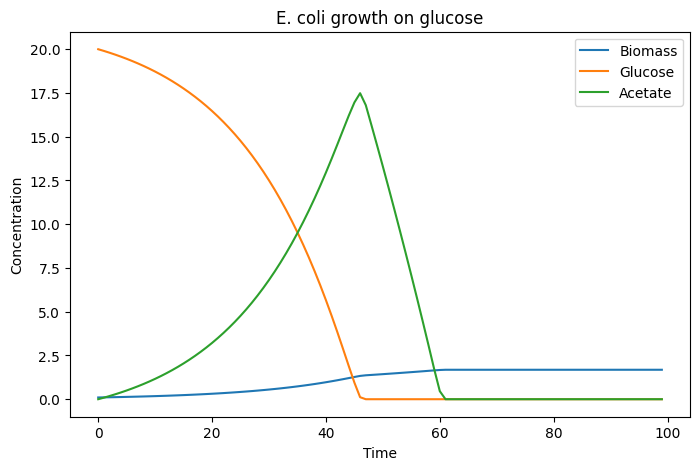

In [4]:
# visualize
plot_dfba_results(time_points, dfba_results, title='E. coli growth on glucose')

## Multiple Species dFBA

Multiple Species dFBA extends dFBA to simulate interactions between multiple microbial species within a shared environment, enabling the study of metabolic cross-feeding.

In [5]:
# Initialize models for each species
model_species_1 = model  # Assuming 'model' is your original model
model_species_2 = copy.deepcopy(model)  # Create a deep copy for the second species

# Assuming model_species_2 is the one to modify
glucose_import_reaction_id = 'EX_glc__D_e'  # Example reaction ID for glucose import
model_species_2.reactions.get_by_id(glucose_import_reaction_id).lower_bound = 0

### Methods for multiple species dFBA

In [6]:
def update_shared_environment(initial_conditions, *species_results):
    """
    Update the shared environment based on the dFBA results of multiple species.
    Assumes results from perform_dfba include net changes in substrate concentrations.
    - initial_conditions: A dictionary of initial concentrations for substrates and biomass.
    - species_results: Variable number of dictionaries, each representing dFBA results for a species.
    """
    # Initialize changes dictionary to store net changes in substrates
    changes = {substrate: 0.0 for substrate in initial_conditions}

    # Calculate net changes for each shared substrate
    for substrate in changes:
        total_change = sum(result[substrate][-1] - initial_conditions[substrate] for result in species_results)
        changes[substrate] = total_change / len(species_results)

    # Update initial_conditions for the next iteration for shared substrates
    for substrate, change in changes.items():
        initial_conditions[substrate] = max(0, initial_conditions[substrate] + change)

    # Update the initial_conditions for the next iteration for biomass of each species
    for i, result in enumerate(species_results, start=1):
        biomass_key = f'biomass_species_{i}'
        if biomass_key in initial_conditions:
            initial_conditions[biomass_key] = result[biomass_key][-1]


def perform_multi_species_dfba(initial_conditions, species_list, dt, n_timepoints=1):
    """
    Perform a multi-species dynamic FBA simulation for a given number of timepoints.

    Parameters:
    - initial_conditions (dict): Initial conditions for biomass and substrates.
    - species_list (list of dicts): Each dict contains species-specific information and dFBA parameters.
    - dt (float): Timestep duration.
    - n_timepoints (int, optional): Number of time points to simulate, default is 1.

    The species_list dict format:
    {
        'model': model_object,  # The metabolic model for the species
        'kinetic_params': dict,  # {substrate: (Km, Vmax)}
        'substrate_update_reactions': dict,  # {substrate: reaction_id}
        'biomass_reaction': str,  # ID of the biomass reaction
        'biomass_identifier': str,  # Key in initial_conditions representing this species' biomass
    }
    """
    state = copy.deepcopy(initial_conditions)
    sim_results = {key: [value] for key, value in state.items()}

    # Perform dFBA for each time step
    for t_i in range(n_timepoints):
        dfba_results = []

        # Perform dFBA for each species
        for species in species_list:
            dfba_result = perform_dfba(
                species['model'],
                state,
                species['kinetic_params'],
                [0, dt],  # This now indicates a single step of duration dt
                species['biomass_reaction'],
                species['substrate_update_reactions'],
                dt,
                species['biomass_identifier'],
            )
            dfba_results.append(dfba_result)
            
            # Update biomass in simulation results
            sim_results[species['biomass_identifier']].append(dfba_result[species['biomass_identifier']][-1])

        # Update the shared environment
        update_shared_environment(state, *dfba_results)

        # Update substrate concentrations in simulation results
        for substrate in [k for k in state.keys() if k not in ['biomass_species_1', 'biomass_species_2']]:
            sim_results[substrate].append(state[substrate])

    return sim_results

### Example Multiple Species dFBA

In this simulation, we explore the interactions between two microbial species in a shared environment, utilizing dFBA. 

- **Species 1** thrives on glucose. As a byproduct of its metabolism, it produces acetate.
- **Species 2** consumes the acetate produced by Species 1. This interdependence highlights a consumer-resource dynamic, where the waste product of one species serves as a crucial resource for another.
- Both species start with equal biomass concentrations, indicating a balanced beginning for this ecological interaction.
- The environment is initially rich in glucose but lacks acetate, setting the stage for the metabolic activities of the species.


In [7]:
# Set initial conditions for both species and the shared environment
initial_conditions = {
    'biomass_species_1': 0.1, 
    'biomass_species_2': 0.1,  # Initial biomass for each species
    'glucose': 20.0, 
    'acetate': 0.0  # Shared environment conditions
}

# (Km, Vmax) for both species
kinetic_params_species_1 = {
    'glucose': (0.5, 2), 
    'acetate': (0.5, 0.02)
}  
kinetic_params_species_2 = {
    'glucose': (0.5, 0.02), 
    'acetate': (0.05, 2)
}  # Different kinetic params for species 2

# which reactions are used
substrate_update_reactions_species_1 = {
    'glucose': 'EX_glc__D_e', 
    'acetate': 'EX_ac_e'
}
substrate_update_reactions_species_2 = {
    'glucose': 'EX_glc__D_e', 
    'acetate': 'EX_ac_e',
}

# Define shared time points and dt
t_n = 200 # number of time points
dt = 0.5  # Time step, matching your setup

# Assuming model_species_1 and model_species_2 are defined and initialized elsewhere
species_info = [
    {
        'model': model_species_1,
        'kinetic_params': kinetic_params_species_1,
        'substrate_update_reactions': substrate_update_reactions_species_1,
        'biomass_reaction': 'Biomass_Ecoli_core',  # Example reaction ID, adjust as needed
        'biomass_identifier': 'biomass_species_1',
    },
    {
        'model': model_species_2,
        'kinetic_params': kinetic_params_species_2,
        'substrate_update_reactions': substrate_update_reactions_species_2,
        'biomass_reaction': 'Biomass_Ecoli_core',  # Example reaction ID, adjust as needed
        'biomass_identifier': 'biomass_species_2',
    },
]

# Call the perform_multi_species_dfba function with the specified parameters
multispecies_results = perform_multi_species_dfba(
    initial_conditions=initial_conditions,
    species_list=species_info,
    dt=dt,
    n_timepoints=t_n,
)

#### plot results

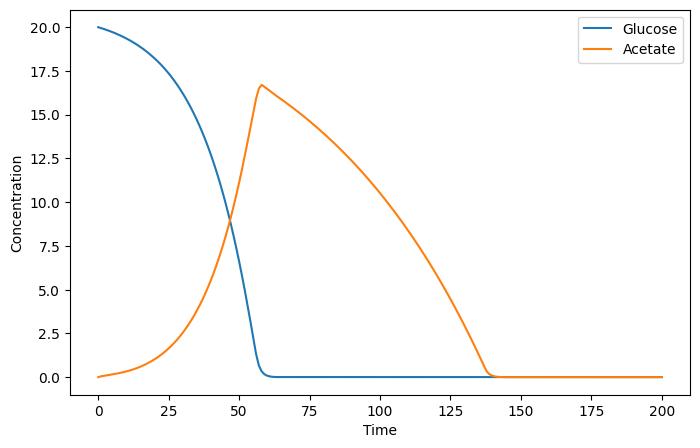

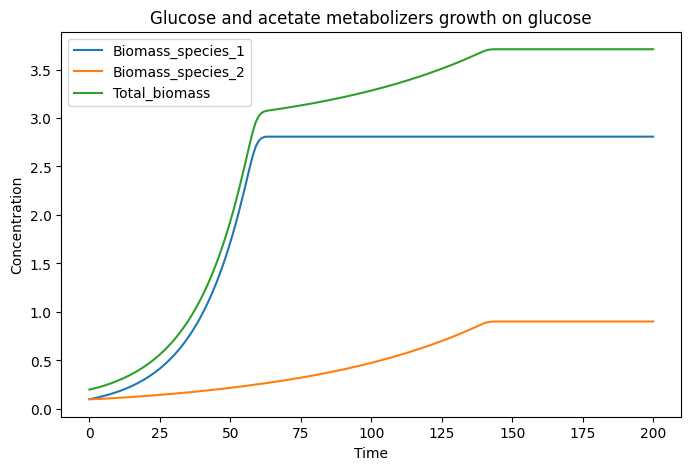

In [8]:
time_points = list(range(0, t_n+1))

# plot metabolites
metabolite_results = {key: multispecies_results[key] for key in multispecies_results if key in ['glucose', 'acetate']}
plot_dfba_results(time_points, metabolite_results)

# plot biomass
biomass_results = {key: multispecies_results[key] for key in multispecies_results if 'biomass' in key}
total_biomass = [multispecies_results['biomass_species_1'][i] + multispecies_results['biomass_species_2'][i] for i in range(len(time_points))]
biomass_results['total_biomass'] = total_biomass

plot_dfba_results(time_points, biomass_results, title='Glucose and acetate metabolizers growth on glucose')

## 2D PDE Diffusion/Advection
This approach models the physical processes of diffusion and advection in two dimensions, providing a way to simulate how substances spread and are transported across a spatial domain, essential for understanding patterns of concentration over time and space.

### Methods for 2D diffusion and advection

In [21]:
# Laplacian for 2D diffusion
LAPLACIAN_2D = np.array([[0,  1, 0],
                         [1, -4, 1],
                         [0,  1, 0]])

def generalized_advection_diffusion_2d(
    initial_states, 
    diffusion_coeffs, 
    advection_fields, 
    total_time, 
    dt,
):
    n_species = len(initial_states)
    current_states = {species: state.copy() for species, state in initial_states.items()}
    solutions = {species: [value] for species, value in initial_states.items()}  # Adjusted for new format
    times = [0]  # To store time points
    n_steps = int(total_time / dt)
    LAPLACIAN_2D = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])  # Example Laplacian kernel
    
    for step in range(n_steps + 1):  # +1 to include the last step
        if step > 0:  # Skip initial state
            times.append(step * dt)
        for species, state in current_states.items():
            
            # Save current state at the beginning
            if step == 0:  # Include initial state
                solutions[species].append(state.copy())

            # Diffusion
            laplacian = convolve(
                state, 
                LAPLACIAN_2D, 
                mode='reflect', 
            ) * diffusion_coeffs[species]

            # Advection
            advective_flux_x = convolve(
                state, 
                np.array([[-1, 0, 1]]), 
                mode='reflect', 
            ) * advection_fields[species][0]
            advective_flux_y = convolve(
                state,
                np.array([[-1], [0], [1]]), 
                mode='reflect', 
            ) * advection_fields[species][1]

            # Update the current state
            updated_state = state + (laplacian + advective_flux_x + advective_flux_y) * dt

            # Ensure non-negativity
            current_states[species] = np.maximum(updated_state, 0)

            # Save updated state
            solutions[species].append(current_states[species].copy())

    # After the loop, add the 'time' key with all time points
    solutions['time'] = times

    return solutions


def plot_species_distributions(results, time_indices, title=''):
    # Check if plot_time_indices are within the range of the 'time' list
    all_times = results['time']
    if any(index >= len(all_times) or index < 0 for index in time_indices):
        raise ValueError("Some of the time_indices are out of the 'time' list range.")
    
    n_times = len(time_indices)
    
    # Exclude 'time' key to get species names
    species_names = [key for key in results.keys() if key != 'time']
    n_species = len(species_names)

    # Compute global min and max for each species
    global_min_max = [(np.min(results[species]), np.max(results[species])) for species in species_names]
    
    fig, axs = plt.subplots(n_times, n_species, figsize=(3*n_species, 3*n_times), squeeze=False)
    for i, time_idx in enumerate(time_indices):
        time = all_times[time_idx]
        for j, species in enumerate(species_names):
            ax = axs[i, j]
            vmin, vmax = global_min_max[j]
            # Access the appropriate data array for the current time and species
            img = ax.imshow(results[species][time_idx], interpolation='nearest', vmin=vmin, vmax=vmax)
            ax.set_title(f'{species} at t = {time:.2f}s')
            plt.colorbar(img, ax=ax)
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_species_distributions_to_gif(results, filename='species_distribution.gif', title='', skip_frames=1):
    species_names = [key for key in results.keys() if key != 'time']
    n_species = len(species_names)
    times = results['time']
    n_times = len(times)

    # Assuming all species have the same number of time steps and that time steps match across species
    global_min_max = [(np.min(results[species]), np.max(results[species])) for species in species_names]
    
    images = []
    for i in range(0, n_times, skip_frames):
        fig, axs = plt.subplots(1, n_species, figsize=(5*n_species, 4))
        if n_species == 1:
            axs = [axs]
        
        for j, species in enumerate(species_names):
            ax = axs[j]
            vmin, vmax = global_min_max[j]
            img = ax.imshow(results[species][i], interpolation='nearest', vmin=vmin, vmax=vmax)
            ax.set_title(f'{species} at t = {times[i]:.2f}s')
            plt.colorbar(img, ax=ax)
        
        fig.suptitle(title, fontsize=16)
        plt.subplots_adjust(wspace=0.05, hspace=0.2)  # Adjust subplot spacing
        plt.tight_layout(pad=0.2)

        # Save the current figure to a temporary buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)
    
    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="{title}" style="max-width:100%;"/>'))

### Example

In [10]:
# Set the dimensions of the simulation grid.
width = 5
height = 10

# Initialize acetate concentration across the grid to zero.
acetate_field = np.zeros((height, width))

# Generate a vertical glucose concentration gradient from 1 at the top to 0 at the bottom.
vertical_gradient = np.linspace(1, 0, height).reshape(-1, 1)  # Create the gradient for a single column.
glc_field = np.repeat(vertical_gradient, width, axis=1)  # Replicate the gradient across all columns.

# Initialize biomass concentration, seeding a specific row with biomass to simulate an initial population.
biomass_field = np.zeros((height, width))  # Start with a grid of zeros.
biomass_field[1:2,:] = 1.0  # Set biomass concentration to 1.0 in the second row.

# Package the initial states into a dictionary for easy access and manipulation.
initial_states = {
    'glucose': glc_field,
    'acetate': acetate_field,  
    'biomass': biomass_field,
}

# Define diffusion coefficients for each substance in the simulation.
# These values dictate how quickly each substance diffuses across the grid.
diffusion_coeffs = {
    'glucose': 0.01,  # Diffusion coefficient for glucose.
    'acetate': 0.01,  # Diffusion coefficient for acetate.
    'biomass': 0.0,   # Biomass does not diffuse in this simulation.
}

# Define advection fields for each substance.
# These tuples represent the direction and speed of substance movement due to advection.
advection_fields = {
    'glucose': (0, 0),   # No advection for glucose.
    'acetate': (0, 0),   # No advection for acetate.
    'biomass': (0, 0.02) # Biomass is subjected to downward advection.
}

# Define the total simulation time.
totaltime = 1500

# Simulate advection and diffusion over the specified total time with a given timestep.
# This function applies the defined physical processes to evolve the distribution of substances.
advection_solutions = generalized_advection_diffusion_2d(
    initial_states,  # The starting concentrations of each substance.
    diffusion_coeffs,  # How quickly each substance diffuses.
    advection_fields,  # The direction and speed of advective transport.
    total_time=totaltime,  # The total time over which to run the simulation.
    dt=0.02,  # The timestep size for each iteration of the simulation.
)

#### plot results


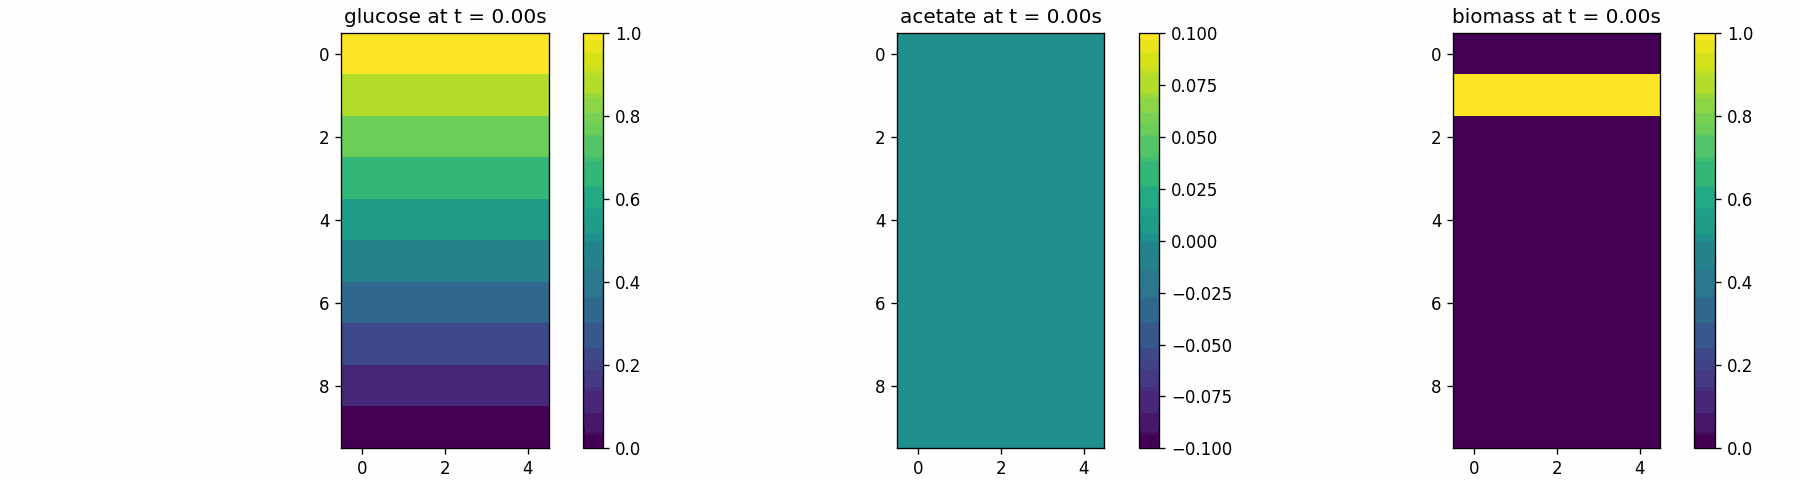

In [22]:
plot_species_distributions_to_gif(
    advection_solutions, 
    skip_frames=1000)

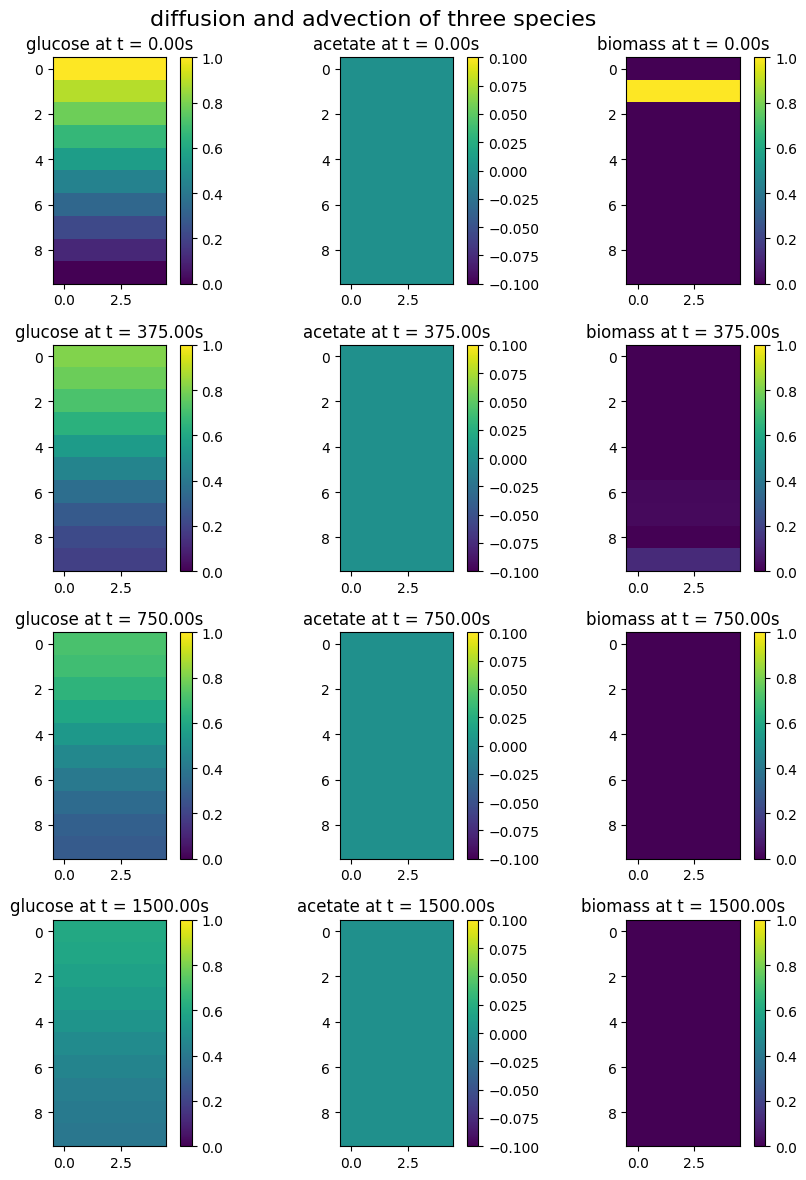

In [12]:
n_times = len(advection_solutions['time'])
time_indices=[0, int(n_times/4), int(n_times/2), n_times-1]
plot_species_distributions(
    advection_solutions, 
    time_indices=time_indices, 
    title='diffusion and advection of three species'
)

## COMETS (Computation Of Microbial Ecosystems in Time and Space)
COMETS combines dynamic FBA with spatially resolved physical processes (like diffusion and advection) to simulate the growth, metabolism, and interaction of microbial communities within a structured two-dimensional environment, capturing both biological and physical complexities.

### Methods for COMETS

In [13]:
def comets_timestep(initial_states, species_info, dt):
    """
    Perform a spatially resolved dFBA simulation on a grid for any number of fields.

    Parameters:
    - initial_states (dict of np.arrays): Initial states for various fields (e.g., glucose, acetate, biomass).
    - species_info (list of dicts): Information for each species for dFBA.
    - dt (float): Time step size.
    """
    # Initialize dictionaries to hold the updated states
    updated_states = {key: np.zeros_like(value) for key, value in initial_states.items()}

    # Assume all fields have the same dimensions
    height, width = next(iter(initial_states.values())).shape

    # Iterate through each grid site
    for y in range(height):
        for x in range(width):
            # Prepare initial conditions for the site by taking the value from each field at (y, x)
            site_initial_conditions = {key: value[y, x] for key, value in initial_states.items()}

            # Perform dFBA for the site
            sim_results = perform_multi_species_dfba(
                site_initial_conditions, 
                species_info, 
                dt)

            # Update fields with the final state from dFBA results
            for key in updated_states:
                if key in sim_results:
                    updated_states[key][y, x] = sim_results[key][-1]

    return updated_states


def simulate_comets_diffuse(initial_states, species_info, diffusion_coeffs, advection_fields, total_time, dt, save_every=1):
    """
    Orchestrate a simulation using the comets_timestep function over a specified duration,
    including advection and diffusion processes.

    Parameters:
    - initial_states (dict of np.arrays): Initial states for each field (e.g., glucose, acetate, biomass).
    - species_info (list of dicts): Information for each species for dFBA.
    - diffusion_coeffs (list of floats): Diffusion coefficients for each field.
    - advection_fields (list of tuples): Advection fields for each field (2D vectors).
    - total_time (float): Total time to simulate.
    - dt (float): Time step size for each call to comets_timestep.
    - save_every (int): How often to save the state (in number of steps).

    Returns:
    - A dictionary containing time-series data for each field.
    """
    current_time = 0
    step_count = 0

    # Initialize a dictionary to hold time-series data for each field, including the initial state
    time_series = {key: [value.copy()] for key, value in initial_states.items()}
    time_series['time'] = [current_time]

    total_steps = int(total_time / dt)
    
    pbar = tqdm(total=total_steps, desc='Simulation Progress')
    start_time = time.time()
    
    current_states = initial_states.copy()
    while current_time < total_time:
        # Apply advection and diffusion for a single timestep (dt)
        solutions = generalized_advection_diffusion_2d(
            current_states, 
            diffusion_coeffs, 
            advection_fields, 
            dt,  # Single timestep
            dt
        )

        # The last updated state for each field is already in the correct format for dFBA simulation
        # No need for conversion back and forth between list and dict
        updated_states_dict = {field: solutions[field][-1] for field in solutions if field != 'time'}
        
        # Perform dFBA with the updated states from advection and diffusion
        updated_states = comets_timestep(updated_states_dict, species_info, dt)
        
        # Update current_states with the results from dFBA for the next iteration
        current_states.update(updated_states)

        # Save the state of the system at this timestep if it's one of the selected steps
        if step_count % save_every == 0:
            for key, value in current_states.items():
                time_series[key].append(value.copy())
            time_series['time'].append(current_time)

        current_time += dt
        step_count += 1
        pbar.update(1)

    pbar.close()
    total_simulation_time = time.time() - start_time
    print(f"Simulation completed in {total_simulation_time:.2f} seconds.")
    
    return time_series

### Example #1 Sinking Biomass
In this COMETS simulation, we start with a spatially resolved environment with a linear glucose gradient, decreasing from the top to the bottom of the grid. A small amount of microbial biomass is initially introduced into a specific row. As the simulation progresses, this allows us to observe several key processes:

- **Biomass Growth**: Leveraging the available glucose, the biomass grows. This growth is modeled dynamically, reflecting how microbes metabolize glucose under the given conditions.
- **Acetate Production**: As a byproduct of metabolism, acetate is produced by the biomass. This simulation tracks the creation and distribution of acetate within the environment.
- **Advection**: The simulation also incorporates advection, specifically affecting the biomass. This results in a "sinking" effect, where the biomass gradually moves downward through the grid over time.

In [14]:
# Define the dimensions of the simulation grid
width = 3
height = 8

# Initialize the acetate concentration field with zeros
acetate_field = np.zeros((height, width))

# Create a linear glucose concentration gradient from 1 (top) to 0 (bottom) vertically
max_glc = 40
vertical_gradient = np.linspace(max_glc, 0, height).reshape(-1, 1)
glc_field = np.repeat(vertical_gradient, width, axis=1)

# Initialize the biomass concentration field, setting a small biomass concentration in a specific row
biomass_field = np.zeros((height, width))
biomass_field[1:2,:] = 0.1  # Introduce initial biomass in the second row

# Initial states of the simulation, mapping each substance to its corresponding field
initial_states = {
    'glucose': glc_field,
    'acetate': acetate_field,  
    'biomass_species_1': biomass_field,
}

# Specify diffusion coefficients for glucose, acetate, and biomass_species_1
# These values control the rate of spread for each component in the simulation
diffusion_coeffs = {
    'glucose': 0.03,            # Diffusion coefficient for glucose
    'acetate': 0.01,            # Diffusion coefficient for acetate
    'biomass_species_1': 0.0,   # No diffusion for biomass_species_1, assuming immobile cells
}

# Define advection (flow) fields for glucose, acetate, and biomass_species_1
# Advection fields specify the direction and speed of flow for each component
advection_fields = {
    'glucose': (0, 0),             # No advection for glucose
    'acetate': (0, 0),             # No advection for acetate
    'biomass_species_1': (0, 0.04) # Downward advection for biomass_species_1
} 

# (Km, Vmax) for species 1
kinetic_params_species_1 = {
    'glucose': (0.5, 2), # Km and Vmax for glucose
    'acetate': (0.5, 2)  # Km and Vmax for acetate
}  

# Which reactions are used by species 1
substrate_update_reactions_species_1 = {
    'glucose': 'EX_glc__D_e', 
    'acetate': 'EX_ac_e'
}

# Configure the simulation for species 1, including metabolic model, kinetic parameters, and biomass reaction
species_info = [
    {
        'model': model_species_1,  # Metabolic model for species 1
        'kinetic_params': kinetic_params_species_1,  # Kinetic parameters for species 1
        'substrate_update_reactions': substrate_update_reactions_species_1,  # Substrate uptake reactions for species 1
        'biomass_reaction': 'Biomass_Ecoli_core',  # ID of the biomass reaction, adjust as needed
        'biomass_identifier': 'biomass_species_1',  # Key identifying biomass_species_1 in the simulation
    },
]

# Set the total time and timestep size for the simulation
total_time = 150.0  # Total simulation time in arbitrary units
dt = 0.5  # Timestep size

# Run the simulation with specified parameters, capturing the results
comets_results = simulate_comets_diffuse(
    initial_states, 
    species_info, 
    diffusion_coeffs, 
    advection_fields, 
    total_time, 
    dt
)

Simulation Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Simulation completed in 5.62 seconds.


#### plot results


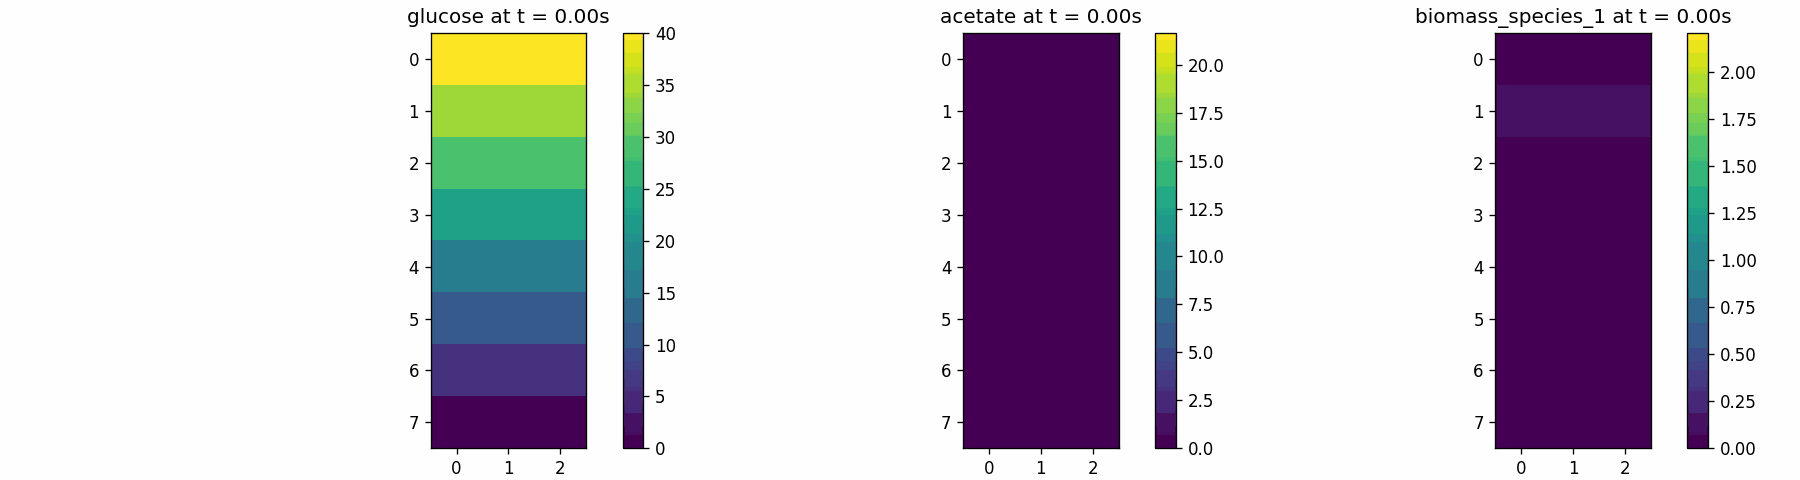

In [23]:
plot_species_distributions_to_gif(
    comets_results, 
    skip_frames=5)

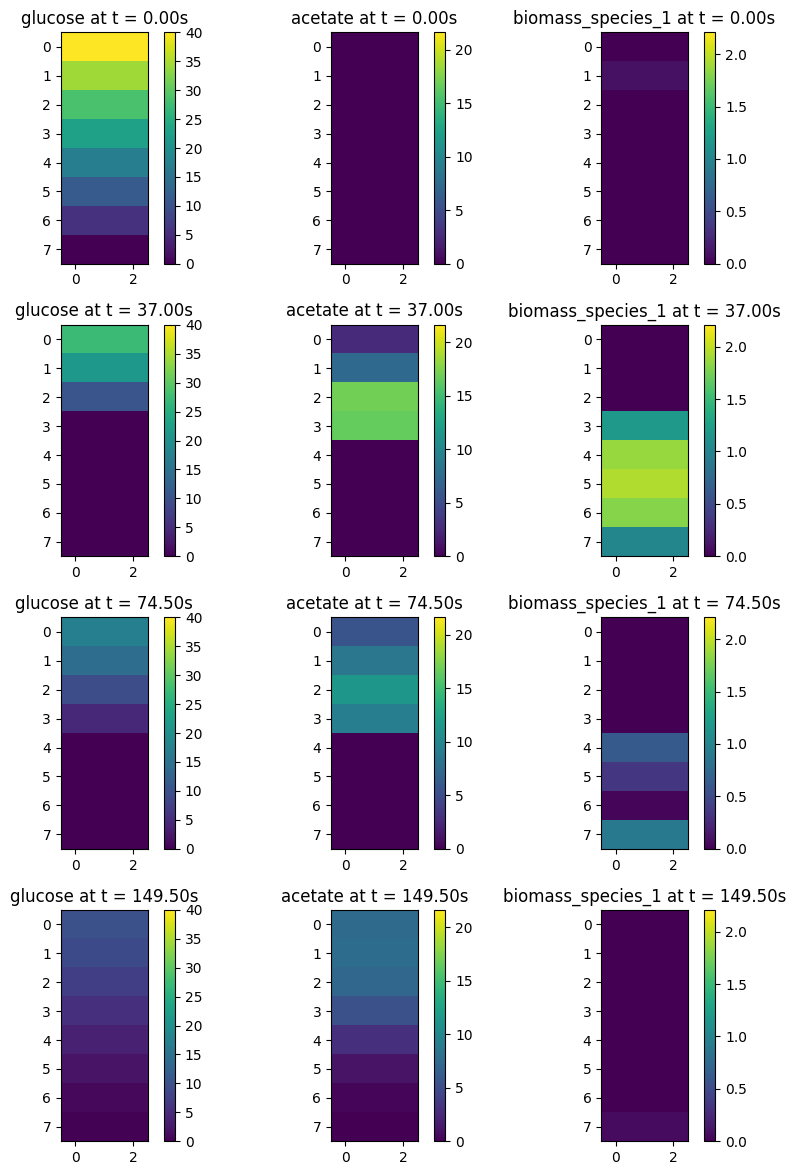

In [16]:
n_times = len(comets_results['time'])
time_indices=[0, int(n_times/4), int(n_times/2), n_times-1]
plot_species_distributions(
    comets_results, 
    time_indices=time_indices)

### Example #2 species growth in 2D

In [17]:
# Define the dimensions of the simulation grid
width = 30
height = 30

# Initialize the acetate concentration field with zeros
acetate_field = np.zeros((height, width))

# Create a linear glucose concentration gradient from 1 (top) to 0 (bottom) vertically
max_glc = 30
glc_field = np.random.rand(height, width) * max_glc

# Initialize the biomass concentration field, setting a small biomass concentration in a specific row
biomass_field = np.zeros((height, width))
biomass_field[int(2*width/5):int(3*width/5), int(2*width/5):int(3*width/5)] = 0.1  # Center concentration

# Initial states of the simulation, mapping each substance to its corresponding field
initial_states = {
    'glucose': glc_field,
    'acetate': acetate_field,  
    'biomass_species_1': biomass_field,
}

# Specify diffusion coefficients for glucose, acetate, and biomass_species_1
# These values control the rate of spread for each component in the simulation
diffusion_coeffs = {
    'glucose': 0.01,            # Diffusion coefficient for glucose
    'acetate': 0.01,            # Diffusion coefficient for acetate
    'biomass_species_1': 0.01,   # No diffusion for biomass_species_1, assuming immobile cells
}

# Define advection (flow) fields for glucose, acetate, and biomass_species_1
# Advection fields specify the direction and speed of flow for each component
advection_fields = {
    'glucose': (0, 0),             # No advection for glucose
    'acetate': (0, 0),             # No advection for acetate
    'biomass_species_1': (0, 0)    # No advection for biomass_species_1
} 

# (Km, Vmax) for species 1
kinetic_params_species_1 = {
    'glucose': (0.5, 2), # Km and Vmax for glucose
    'acetate': (0.5, 2)  # Km and Vmax for acetate
}  

# Which reactions are used by species 1
substrate_update_reactions_species_1 = {
    'glucose': 'EX_glc__D_e', 
    'acetate': 'EX_ac_e'
}

# Configure the simulation for species 1, including metabolic model, kinetic parameters, and biomass reaction
species_info = [
    {
        'model': model_species_1,  # Metabolic model for species 1
        'kinetic_params': kinetic_params_species_1,  # Kinetic parameters for species 1
        'substrate_update_reactions': substrate_update_reactions_species_1,  # Substrate uptake reactions for species 1
        'biomass_reaction': 'Biomass_Ecoli_core',  # ID of the biomass reaction, adjust as needed
        'biomass_identifier': 'biomass_species_1',  # Key identifying biomass_species_1 in the simulation
    },
]

# Set the total time and timestep size for the simulation
total_time = 100.0  # Total simulation time
dt = 1.0            # Timestep size

# Run the simulation with specified parameters, capturing the results
comets_results2 = simulate_comets_diffuse(
    initial_states, 
    species_info, 
    diffusion_coeffs, 
    advection_fields, 
    total_time, 
    dt
)

Simulation Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Simulation completed in 53.88 seconds.


#### plot results


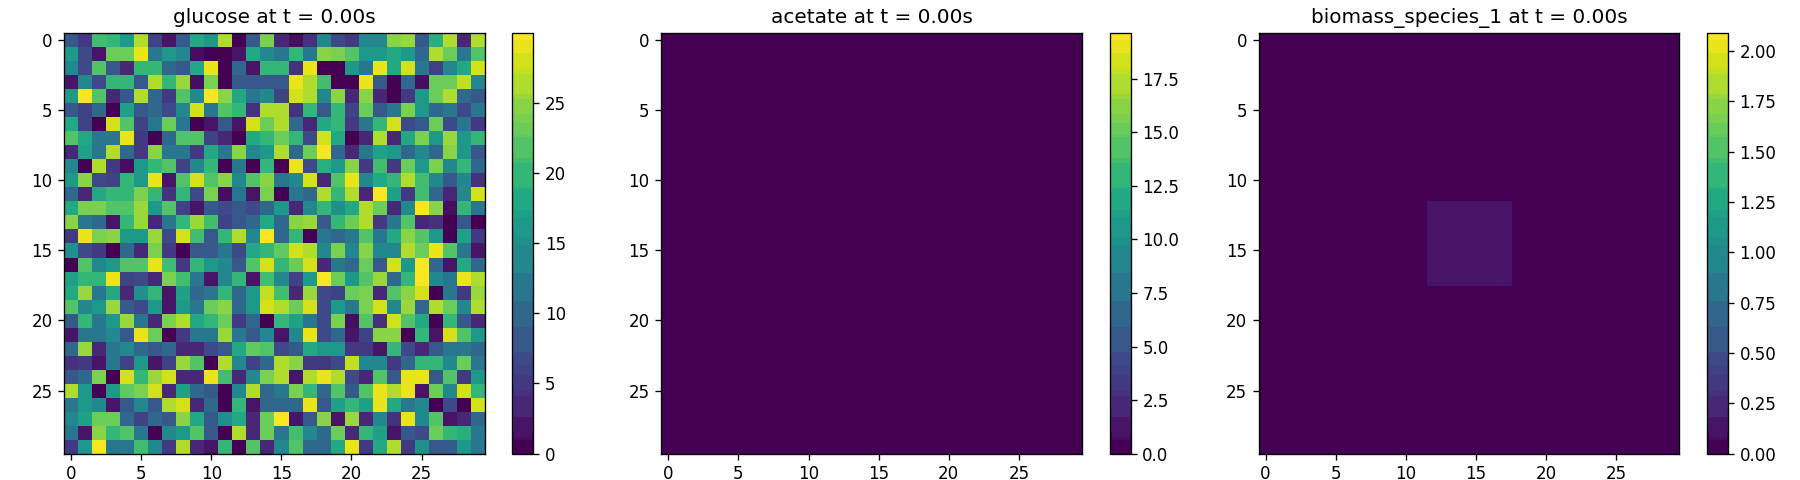

In [18]:
plot_species_distributions_to_gif(
    comets_results2, 
    skip_frames=5)

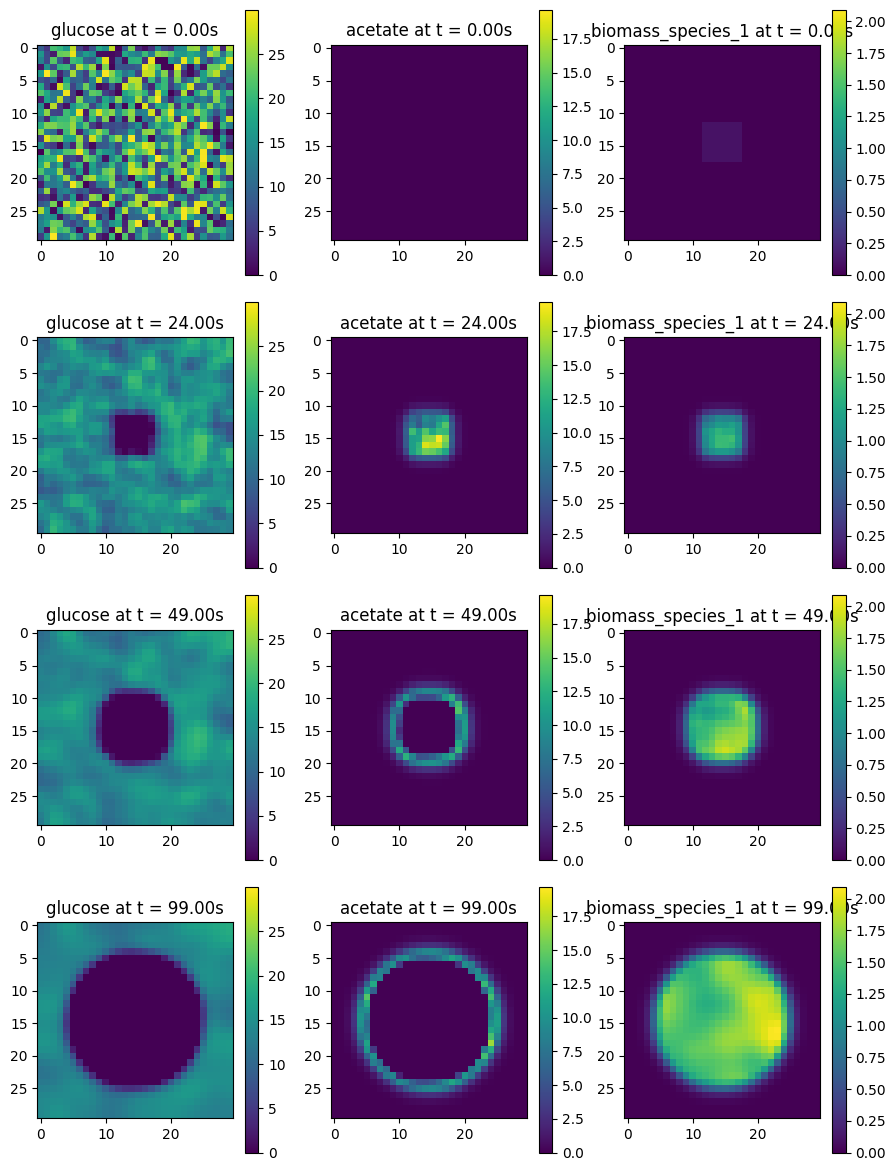

In [19]:
n_times = len(comets_results2['time'])
time_indices=[0, int(n_times/4), int(n_times/2), n_times-1]
# plot_times=[0, total_time/4, total_time/2, total_time-1]
plot_species_distributions(
    comets_results2, 
    time_indices=time_indices)

## Example #3 Two species: glucose and acetate eating

In [20]:
# Define the dimensions of the simulation grid
width = 20
height = 20

# Initialize the acetate concentration field with zeros
acetate_field = np.zeros((height, width))

# Create a linear glucose concentration gradient from 1 (top) to 0 (bottom) vertically
max_glc = 30
glc_field = np.random.rand(height, width) * max_glc

# Initialize the biomass concentration field, setting a small biomass concentration in a specific row
species1_field = np.zeros((height, width))
species1_field[int(2 * width / 5):int(3 * width / 5),
int(2 * width / 5):int(3 * width / 5)] = 0.1  # Center concentration

species2_field = np.zeros((height, width))
species2_field[int(2 * width / 5):int(3 * width / 5),
int(2 * width / 5):int(3 * width / 5)] = 0.1  # Center concentration

# Initial states of the simulation, mapping each substance to its corresponding field
initial_states = {
    'glucose': glc_field,
    'acetate': acetate_field,
    'species_1': species1_field,
    'species_2': species2_field,
}

# Specify diffusion coefficients for glucose, acetate, and biomass_species_1
# These values control the rate of spread for each component in the simulation
diffusion_coeffs = [
    0.01,  # Diffusion coefficient for glucose
    0.01,  # Diffusion coefficient for acetate
    0.01,  # Diffusion for biomass_species_1
    0.01,  # Diffusion for biomass_species_2
]

# Define advection (flow) fields for glucose, acetate, and biomass_species_1
# Advection fields specify the direction and speed of flow for each component
advection_fields = [
    (0, 0),  # No advection for glucose
    (0, 0),  # No advection for acetate
    (0, 0),  # No advection for biomass_species_1
    (0, 0),  # No advection for biomass_species_2
]

# (Km, Vmax) for species 1
kinetic_params_species_1 = {
    'glucose': (0.5, 2),
    'acetate': (0.5, 2)
}
kinetic_params_species_2 = {
    'glucose': (0.5, 0.0),
    'acetate': (0.05, 2)
}

# Which reactions are used by species 1
substrate_update_reactions = {
    'glucose': 'EX_glc__D_e',
    'acetate': 'EX_ac_e'
}

# Configure the simulation for species 1, including metabolic model, kinetic parameters, and biomass reaction
species_info = [
    {
        'model': model_species_1,  # Metabolic model for species 1
        'kinetic_params': kinetic_params_species_1,  # Kinetic parameters for species 1
        'substrate_update_reactions': substrate_update_reactions,  # Substrate uptake reactions for species 1
        'biomass_reaction': 'Biomass_Ecoli_core',  # ID of the biomass reaction, adjust as needed
        'biomass_identifier': 'species_1',  # Key identifying biomass_species_1 in the simulation
    },
    # {
    #     'model': model_species_2,
    #     'kinetic_params': kinetic_params_species_2,
    #     'substrate_update_reactions': substrate_update_reactions,
    #     'biomass_reaction': 'Biomass_Ecoli_core',
    #     'biomass_identifier': 'species_2',
    # },
]

# Set the total time and timestep size for the simulation
total_time = 20.0  # Total simulation time
dt = 1.0           # Timestep size

# # Run the simulation with specified parameters, capturing the results
# comets_results3 = simulate_comets_diffuse(
#     initial_states,
#     species_info,
#     diffusion_coeffs,
#     advection_fields,
#     total_time,
#     dt
# )

Simulation Progress:   0%|          | 0/20 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not str